## Loading spikes from Phy formatted files
Here we will cover the basics of importing spiking data. This includes the file types used to store spiking data, how to load them into python, turn them into a pynapple time series group object, and interacting with the time series group object.

In [1]:
import pynapple as nap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

### File types for storing spiking data
We store our extracted spikes in a format compatible with Phy, a program for manually curating and visualizing extracellularly recorded spike data. It draws upon a collection of files in py (python), npy (numpy array), and tsv (tab seperated value) formats. Each recording electrode during a recording session has its own folder containing the these files. In the lab we deviate a bit from the standards used in Phy. These deviations are noted in italics. New file types not found in Phy are underlined.
1. **params.py**: python file defining variables of recording parameters. Includes sample rate and number of channels. *We also specify the number of time points in the original binary file.*
2. **spike_times.npy**: an N-length array of uint64. The time index of each spike. Divide this by the sample rate to get time in seconds
3. **spike_clusters.npy**: an N-length array of uint32. The unit ID associated with each spike in spike_times.npy.
4. **channel_positions.npy**: an Mx2 numeric array. The location of each of the M recording electrodes. First column is x position, second column is y position.
5. **channel_map.npy**: an Mx1 array of int32. A zero-indexed list of channels in the binary file corresponding to each position in **channel_positions** file.
6. **templates.npy**: a PxTxM numeric array of mean spike waveforms. Not required for loading spiking data.
    - P is the number of templates, one for each unit ID. Templates are in ascending order of unit ID.
    - T is the number of time points sampled around each spike waveform. 
    - M is the number of channels. 

Two additional files are provided that are not part of Phy.
1. **cluster_props.tsv**: a tab separated textual table of properties for each unit. Not required for loading spiking data. First column is the unit ID, followed by unit type (SU/MU) and channel with strongest amplitude. Other information can be added as additional columns (e.g. brain region).

PLANNED, NOT INCLUDED YET

2. **sample_waves.npy**: a PxTxMxQ numeric array of randomly sampled spike waveforms. NaN padding is used for spikes with fewer than Q waves. 
    - P is the number of templates, one for each unit ID. Templates are in ascending order of unit ID.
    - T is the number of time points sampled around each spike waveform. 
    - M is the channel. 
    - Q is the number of waveforms. Typically 100.

In [2]:
# directories and files used to build a pynapple Timestamps Group object
phy_dir = '../test_data/phy/'
param_file = phy_dir + 'params.py'

spk_file = phy_dir + 'spike_times.npy'
clu_file = phy_dir + 'spike_clusters.npy'
prop_file = phy_dir + 'cluster_props.tsv'
pos_file = phy_dir + 'channel_positions.npy'
map_file = phy_dir + 'channel_map.npy'
tplt_file = phy_dir + 'templates.npy'

Here is how you can load each of these files into your python workspace.

In [3]:
# import params.py file
sys.path.append(phy_dir)
import params as params

samp_num = params.n_samples_dat
samp_rate = params.sample_rate

# get the spike times
spk_times = np.load(spk_file)

# get the cluster assigned to each spike and a list of the clusters present
clu_ids = np.load(clu_file)
clu_id_list = np.unique(np.sort(clu_ids))

# get properties for each cluster
clu_props = pd.read_csv(prop_file, sep='\t', index_col='cluster_id')

# get electrode mapping and their spatial positions
chan_map = np.load(map_file)
chan_pos = np.load(pos_file)

# for cluster identify the position of the electrode it was closest to
clu_props['x_pos'] = clu_props['peak_chan'].map(
                        lambda x: chan_pos[np.flatnonzero(chan_map==x),0])
clu_props['y_pos'] = clu_props['peak_chan'].map(
                        lambda x: chan_pos[np.flatnonzero(chan_map==x),1])   

# get spike waveforms
spk_waves = np.load(tplt_file)        
spk_waves = [np.squeeze(x) for x in np.split(spk_waves,spk_waves.shape[0],axis=0)]
clu_props['wave'] = pd.Series(spk_waves,index=clu_id_list)


Once each of the files have been loaded, we can used them to create a time series group object. This object is part of the pynapple package and provides numerous methods for working with spiking data. An introduction to the time series and time series group object can be found [here](https://peyrachelab.github.io/pynapple/notebooks/pynapple-core-notebook/).

In [4]:
sess_set = nap.IntervalSet(0, samp_num/samp_rate)

spk_dict = {}
for id in clu_id_list:
    spk_dict[id] = nap.Ts(spk_times[clu_ids==id]/samp_rate,time_units='s',
                          time_support=sess_set)

spk_grp = nap.TsGroup(spk_dict)
spk_grp.set_info(clu_props)

If we print the output for the time series group object we get a helpful summary of the units in our recording.

In [5]:
print(spk_grp)

  Index    rate  type      peak_chan    x_pos    y_pos  wave
-------  ------  ------  -----------  -------  -------  -------------------------
      0    1.39  SU               78       11      780  [[ 0  0  0 ...  0  0  0]
                                                         [ 0  0  0 ...  0  0  0]
                                                         [ 0  0  0 ...  0  0  0]
                                                         ...
                                                         [ 0 -1 -1 ...  0  0  0]
                                                         [ 0  0  0 ...  0  0  0]
                                                         [ 0  0  0 ...  0  0  0]]
      1    1.74  SU               85       59      840  [[-1  0  0 ...  0  0  0]
                                                         [-1  0  0 ...  0  0 -1]
                                                         [ 0  0  0 ...  0  0  0]
                                                         ...
     

### Loading spikes from Phy files with single function
Instead of loading each file individually and constructing our time series group object from them, we have a dedicated function to do just that.

In [6]:
# import function for loading phy files as pynapple TsGroup
sys.path.append('../code/') # for relative import in jupyter notebook
from fileio.loadphy import as_pynapple

# call the function
spks = as_pynapple(phy_dir)

### Using the time series group object
Below are some examples of common ways to access data from the time series group object.

In [7]:
# List the unit IDs in this session
grp_ids = spks.index
print('Spike group IDs: {}\n'.format(grp_ids))

Spike group IDs: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]



In [8]:
# Get a pandas series object listing the firing rates of the units
grp_rates = spks.rates
print('Firing rates are:\n{}\n'.format(grp_rates))

Firing rates are:
0     1.393359
1     1.743313
2     1.165271
3     3.276152
4     2.325227
5     1.337096
6      1.86214
7     2.619145
8     7.492296
9     3.419277
10      5.6256
11    7.598064
12    6.824507
13    2.901142
14    3.750248
Name: rate, dtype: object



In [9]:
# Get the time series object of a specific unit
sel_unit = spks[8]

# Get that unit's spike times
sel_spk = sel_unit.index.values
print('Spike times: {}\n'.format(sel_spk))

# First and last spike times
sel_spk_first = sel_spk[0]
sel_spk_last = sel_spk[-1]
print('First spike: {first:0.4f} sec\nLast spike: {last:0.4f} sec\n'.format(
        first=sel_spk_first, last=sel_spk_last))

# Get that unit's y-position on the probe
sel_spk_y = spks.get_info('y_pos')[8]
print('Y position: {} um\n'.format(sel_spk_y))

Spike times: [1804.43696667 1804.45943333 1804.46676667 ... 9761.0512     9761.87216667
 9762.69596667]

First spike: 1804.4370 sec
Last spike: 9762.6960 sec

Y position: 1180.0 um



In [10]:
# Last spike time across all units
last_spk = np.max([x.index.values[-1] for x in spks.values()])
print('Last spike happened at {:0.4f} sec\n'.format(last_spk))

Last spike happened at 10604.9579 sec



In [11]:
# get just the unit's with firing rates greater than 5 Hz
hf_spks = spks.getby_threshold('rate',5)
print('Units with firing rates greater than 5 Hz\n{}\n'.format(hf_spks))

Units with firing rates greater than 5 Hz
  Index    rate  type      peak_chan    x_pos    y_pos  full_wave                  peak_wave
-------  ------  ------  -----------  -------  -------  -------------------------  -------------------------------------------------------------------------
      8    7.49  SU              118       11     1180  [[-1  0  0 ...  0  0  0]   [[  2   2   2   2   2   2   2   1   1   1   1   0   0   0  -1  -2 -12 -30
                                                         [-1  0 -1 ...  0  0  0]     -47 -56 -52 -36 -17   1  11  14  13  11   9   8   7   6   5   4   4   4
                                                         [-1 -1 -1 ...  0  0  0]       4   3   3   3   3   3   2   3   3   2   2   2   2   2   1   1   1   1
                                                         ...                           1   1   1   1   1   1   0]]
                                                         [ 0  0  0 ...  0  0  0]
                                         

In [12]:
# group together units in 100 um spatial bins
pos_arr = spks.get_info('y_pos').values
pos_bottom = np.floor(np.min(pos_arr)/100)*100
pos_top = np.ceil(np.max(pos_arr)/100)*100
pos_bins = np.arange(pos_bottom,pos_top+100,100)
pos_spks = spks.getby_intervals('y_pos', pos_bins)
print('Units grouped by position along the probe')
for x in pos_spks[0]:
        print('{}\n'.format(x))

Units grouped by position along the probe
  Index    rate  type      peak_chan    x_pos    y_pos  full_wave                  peak_wave
-------  ------  ------  -----------  -------  -------  -------------------------  -------------------------------------------------------------------------
      0    1.39  SU               78       11      780  [[ 0  0  0 ...  0  0  0]   [[  3   3   2   3   2   2   2   2   2   1   1   1   1   1   0  -2  -7 -14
                                                         [ 0  0  0 ...  0  0  0]     -19 -22 -20 -18 -15 -12 -10  -8  -6  -4  -3  -1   0   1   2   3   3   4
                                                         [ 0  0  0 ...  0  0  0]       5   5   5   5   6   6   6   5   5   5   5   5   5   5   4   3   3   2
                                                         ...                           2   2   2   1   1   0   0]]
                                                         [ 0 -1 -1 ...  0  0  0]
                                         

### Visualizing spike waveforms

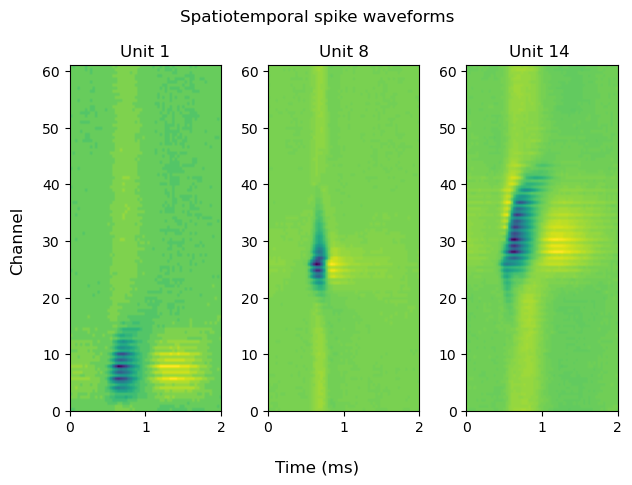

In [13]:
# Get the spike waveforms for a few units
unit1_wave = spks.get_info('full_wave')[1]
unit8_wave = spks.get_info('full_wave')[8]
unit14_wave = spks.get_info('full_wave')[14]


# Plot each unit's spike waveform
def wave_plot(spk_wave,title='',ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # we transpose the waveform so channels are on the y-axis and time on the x-axis
    # this view is more intuitive and commonly used in the literature
    ax.imshow(spk_wave.T,origin='lower',extent=[0,2,0,spk_wave.shape[0]])
    ax.set_aspect('auto')
    ax.set_title(title)
    return ax

fig, ax = plt.subplots(1,3)
wave_plot(unit1_wave,title='Unit 1',ax=ax[0])
wave_plot(unit8_wave,title='Unit 8',ax=ax[1])
wave_plot(unit14_wave,title='Unit 14 ',ax=ax[2])
fig.suptitle('Spatiotemporal spike waveforms')
fig.supylabel('Channel')
fig.supxlabel('Time (ms)')
fig.tight_layout()
plt.show()

You should note here that these waveforms look quite different. In fact, sometimes we can indentify the type of neuron we are recording from just based on these spike waveform shapes. For instance, unit 8 has a fast waveform compared with 3 and 14, indicating that it is a *fast spiking* interneuron. This is better seen if we plot the peak waveforms from each unit on top of one another.

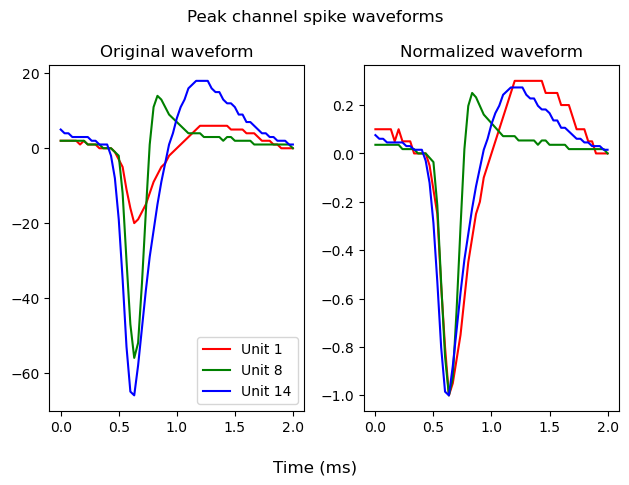

In [14]:
unit1_pwave = spks.get_info('peak_wave')[1]
unit8_pwave = spks.get_info('peak_wave')[8]
unit14_pwave = spks.get_info('peak_wave')[14]
t_pts = np.linspace(0,2,unit1_pwave.size)
fig, ax = plt.subplots(1,2)
ax[0].plot(t_pts,unit1_pwave.T,'r')
ax[0].plot(t_pts,unit8_pwave.T,'g')
ax[0].plot(t_pts,unit14_pwave.T,'b')
ax[1].plot(t_pts,unit1_pwave.T/-np.min(unit1_pwave),'r')
ax[1].plot(t_pts,unit8_pwave.T/-np.min(unit8_pwave),'g')
ax[1].plot(t_pts,unit14_pwave.T/-np.min(unit14_pwave),'b')
ax[0].legend(('Unit 1', 'Unit 8', 'Unit 14'))
ax[0].set_title('Original waveform')
ax[1].set_title('Normalized waveform')
fig.suptitle('Peak channel spike waveforms')
fig.supxlabel('Time (ms)')
fig.tight_layout()
plt.show()


Notice that Unit 8 has a faster spike shape than Unit 1 and 14. This is consistent with Unit 8 having a voltage gated potassium channel with fast kinetics, which is found in fast-spiking interneurons.